In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

In [2]:
wine = pd.read_csv('winequality-red.csv')

wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [3]:
print("Unique values in quality:", sorted(wine.quality.unique()))

Unique values in quality: [3, 4, 5, 6, 7, 8]


In [4]:
wine['quality'] = wine['quality'].apply(lambda value: 'low' if value < 5 else 'medium' if value < 7 else 'high')

In [5]:
wine.quality.value_counts()

quality
medium    1319
high       217
low         63
Name: count, dtype: int64

In [6]:
X = wine.drop('quality', axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
features = wine.drop('quality', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [8]:
scaled_features[:5]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711],
       [ 1.65485608, -1.38444349,  1.4841536 , -0.45321841, -0.26496041,
         0.10759209,  0.41150046,  0.6642772 , -0.97910442, -0.46118037,
        -0.58477711],
       [-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [9]:
pca_2_comp = PCA(n_components=2)
reduced_2 = pca_2_comp.fit_transform(scaled_features)

In [10]:
pca_2d = pd.DataFrame(data=reduced_2, columns=['PC1', 'PC2'])
pca_2d['quality'] = wine['quality']

In [12]:
pca_2_train = pca_2d.drop('quality', axis=1)

In [15]:
gmm = GMM(n_components=3, covariance_type='full', random_state=42)

gmm.fit(pca_2_train)

labels = gmm.predict(pca_2_train)

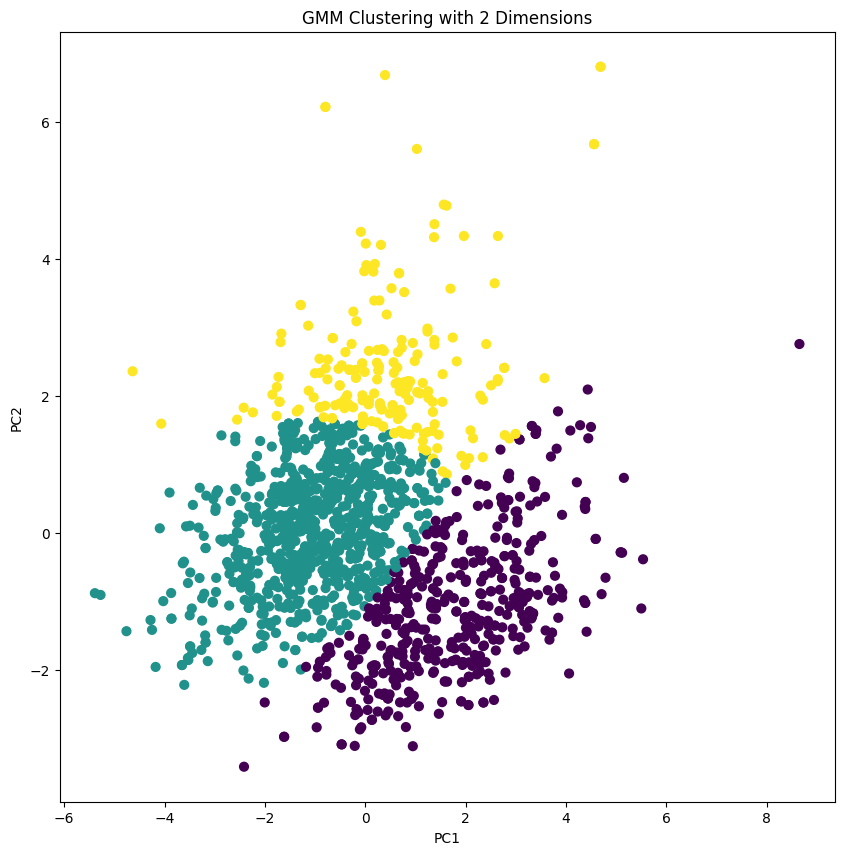

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(pca_2d['PC1'], pca_2d['PC2'], c=labels, s=40, cmap='viridis', zorder=2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('GMM Clustering with 2 Dimensions')
plt.show()

In [80]:
def make_ellipses(gmm, ax, colors, n_std=[1, 2, 3]):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]

        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi

        for ns in n_std:
            v_scaled = 2. * ns * np.sqrt(2.) * np.sqrt(v)
            ell = Ellipse(xy=gmm.means_[n, :2], width=v_scaled[0], height=v_scaled[1],
                          angle=180 + angle, edgecolor=color, facecolor='none',
                          linewidth=2, linestyle='--')
            ax.add_artist(ell)
            ell.set_alpha(0.5 / ns)

def plot_gmm(gmm, X, type, label=True, ax=None):
    plt.figure(figsize=(15, 15))
    
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)

    size = 50 * gmm.predict_proba(X).max(1) ** 2
    
    color_map = ['red', 'green', 'blue']
    colors = [color_map[label] for label in labels]
    
    ax.scatter(X[:, 0], X[:, 1], c=colors, s=size, alpha=0.5)
    
    ax.axis('equal')
    if type == "PCA":
        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')
    if type == "TSNE":
        ax.set_xlabel('TSNE 1')
        ax.set_ylabel('TSNE 2')
    ax.set_title('GMM Clustering with Distributions')

    make_ellipses(gmm, ax, color_map)

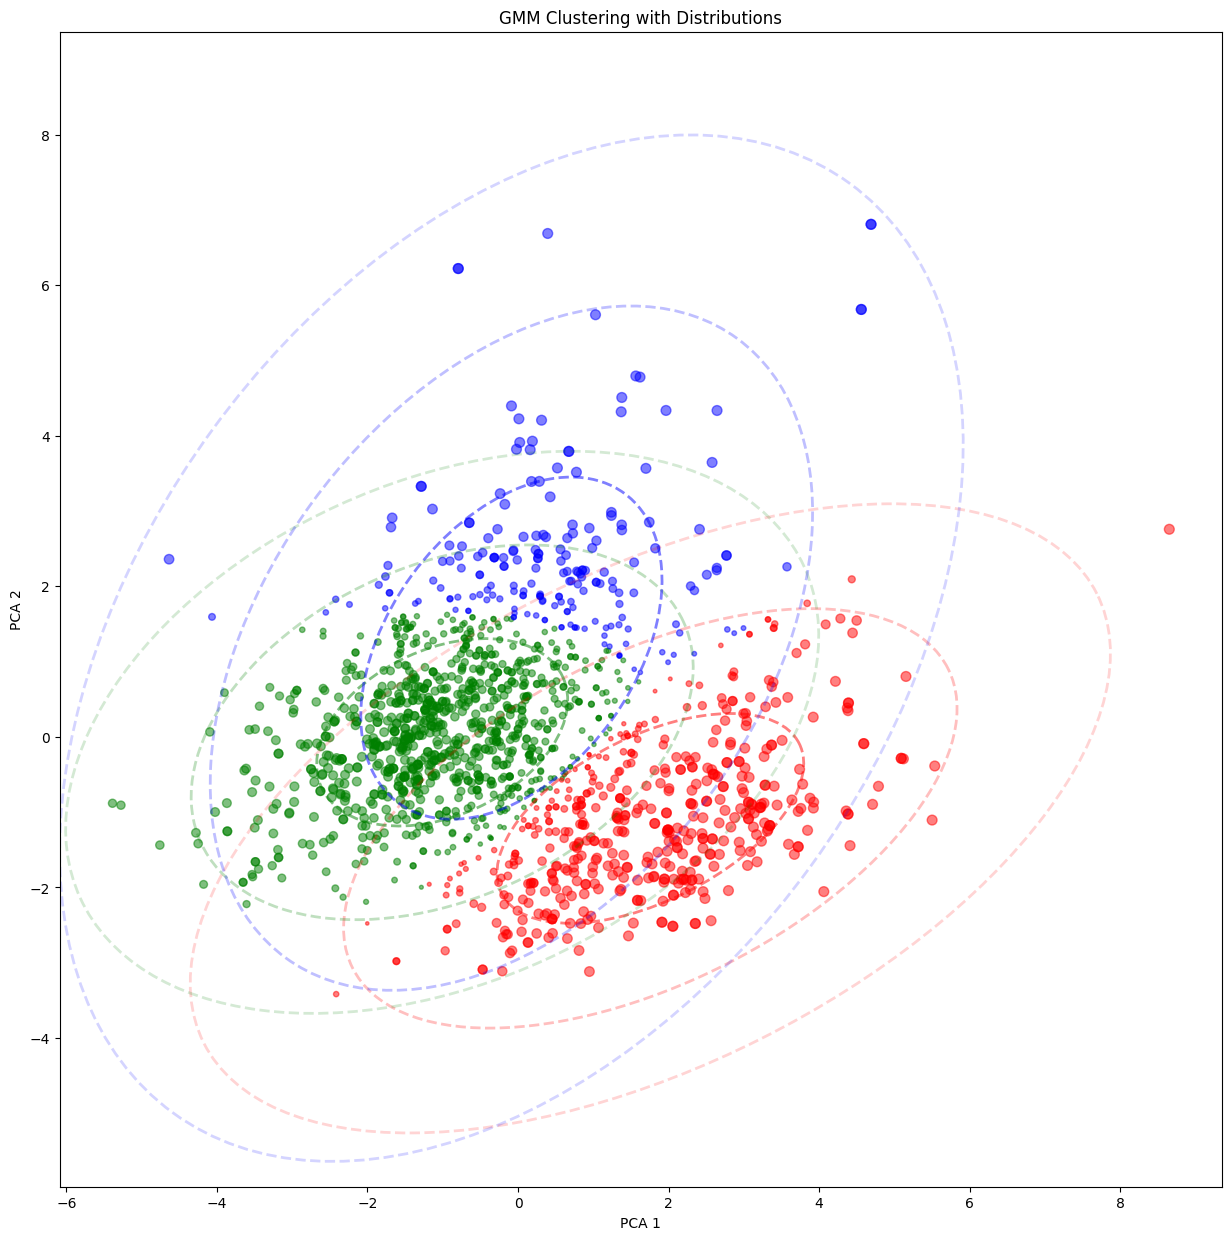

In [91]:
gmm = GMM(n_components=3, covariance_type='full', random_state=42)
plot_gmm(gmm, reduced_2, "PCA")

In [92]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(reduced_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[ 10  47   6]
 [338 786 195]
 [132  82   3]]


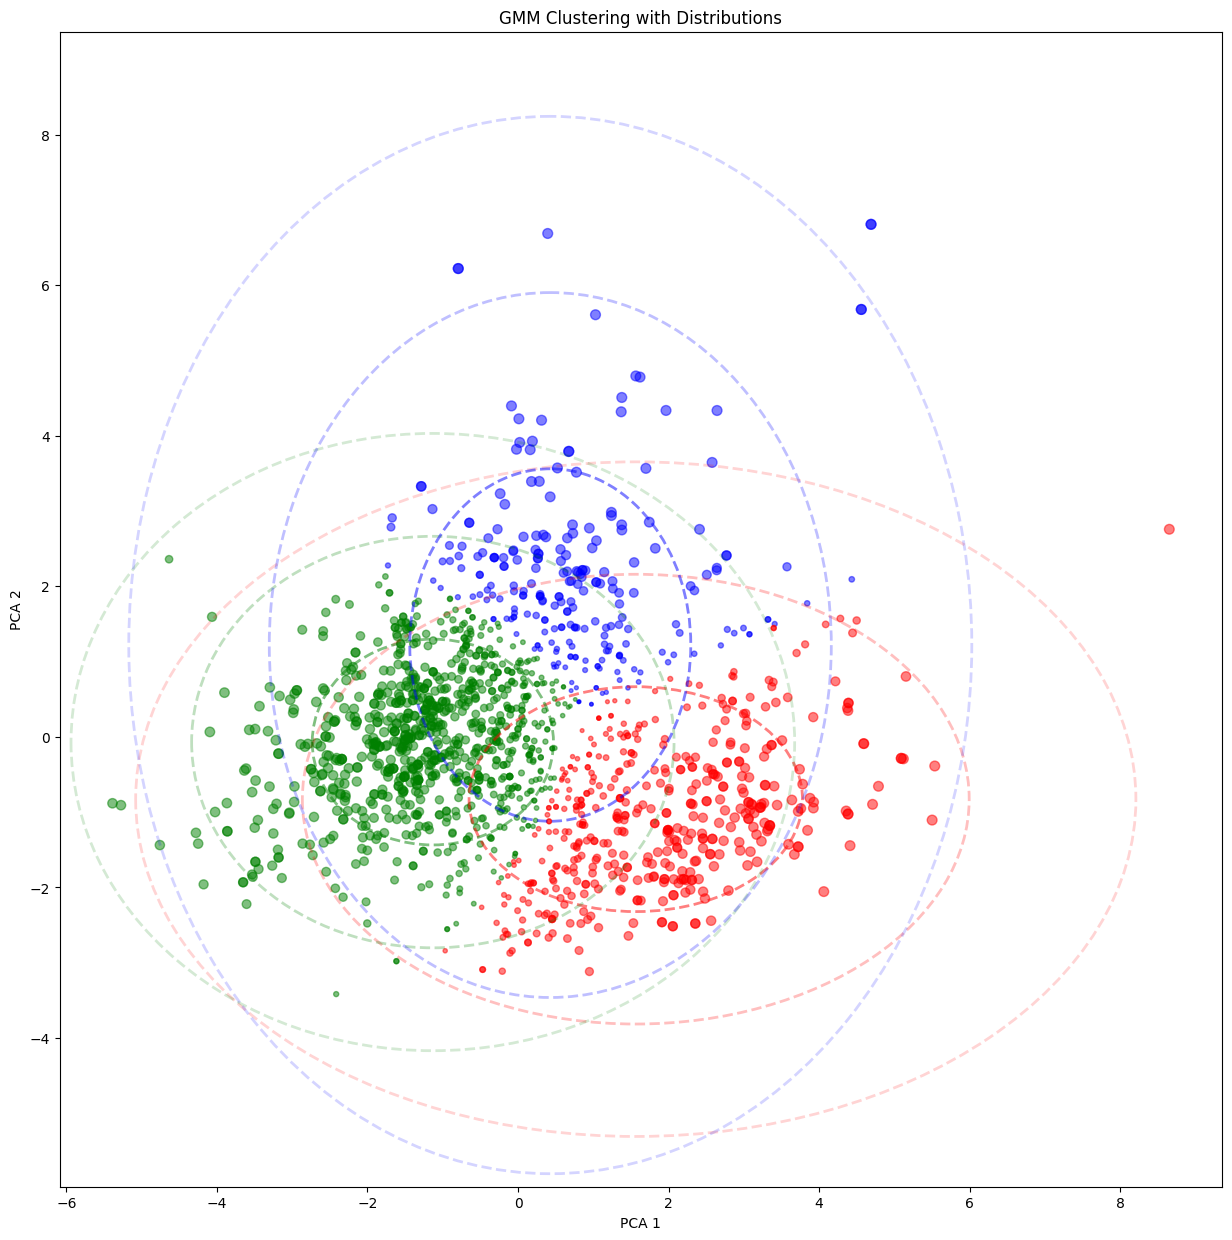

In [93]:
gmm = GMM(n_components=3, covariance_type='diag', random_state=42)
plot_gmm(gmm, reduced_2, "PCA")

In [94]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(reduced_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[ 10  46   7]
 [326 764 229]
 [124  84   9]]


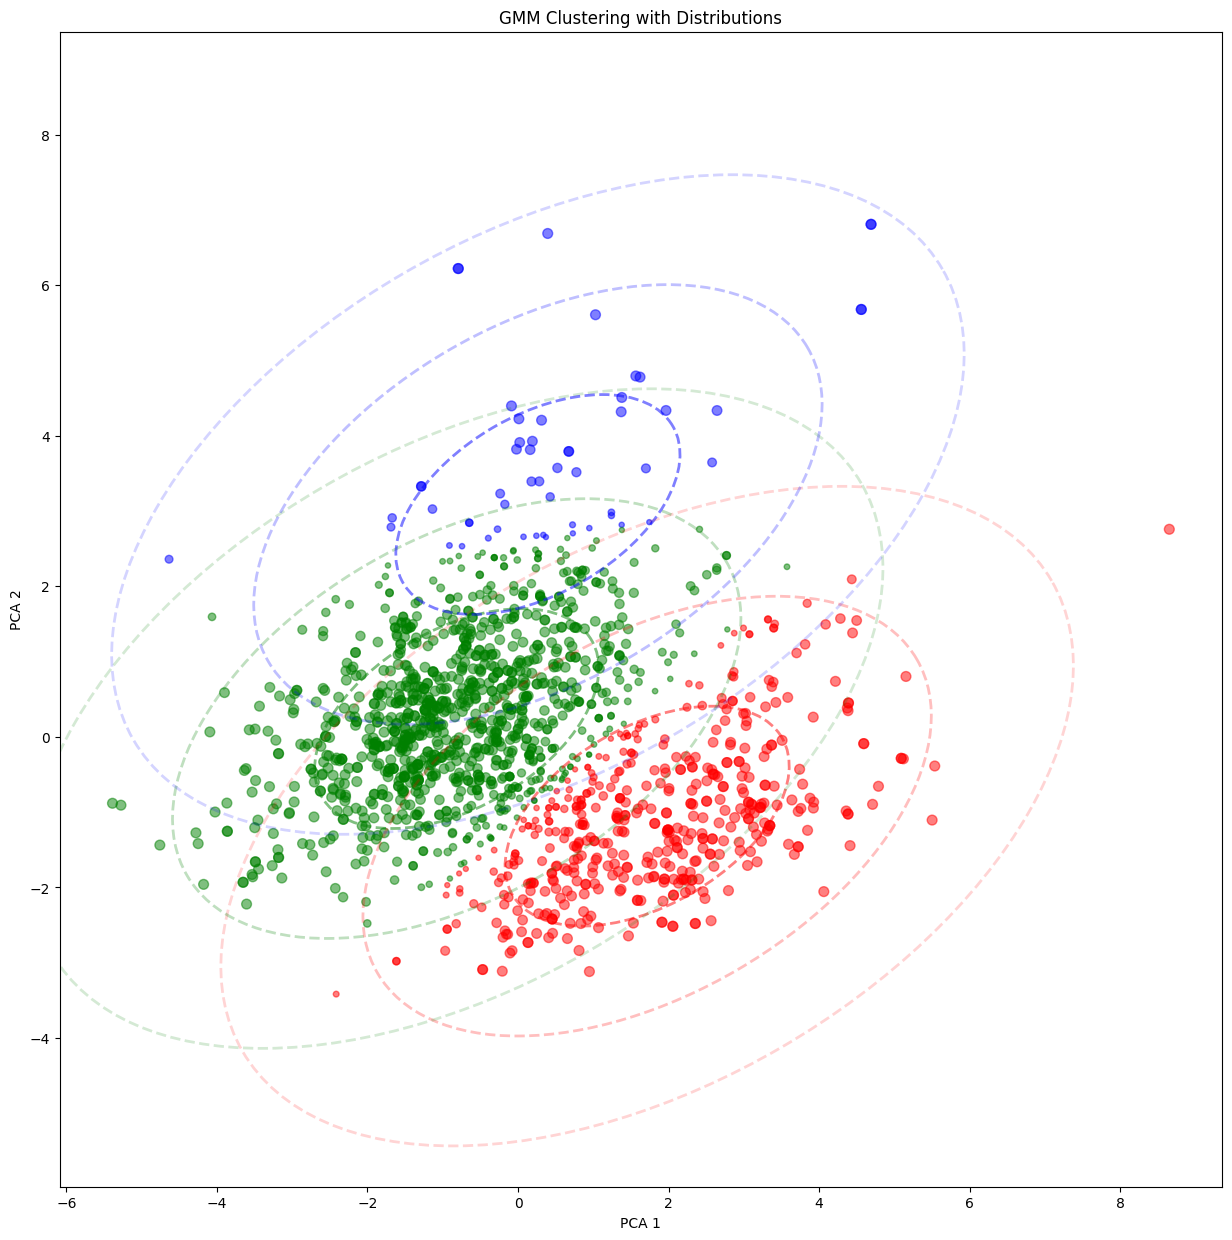

In [95]:
gmm = GMM(n_components=3, covariance_type='tied', random_state=42)
plot_gmm(gmm, reduced_2, "PCA")

In [96]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(reduced_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[  9  53   1]
 [332 935  52]
 [130  85   2]]


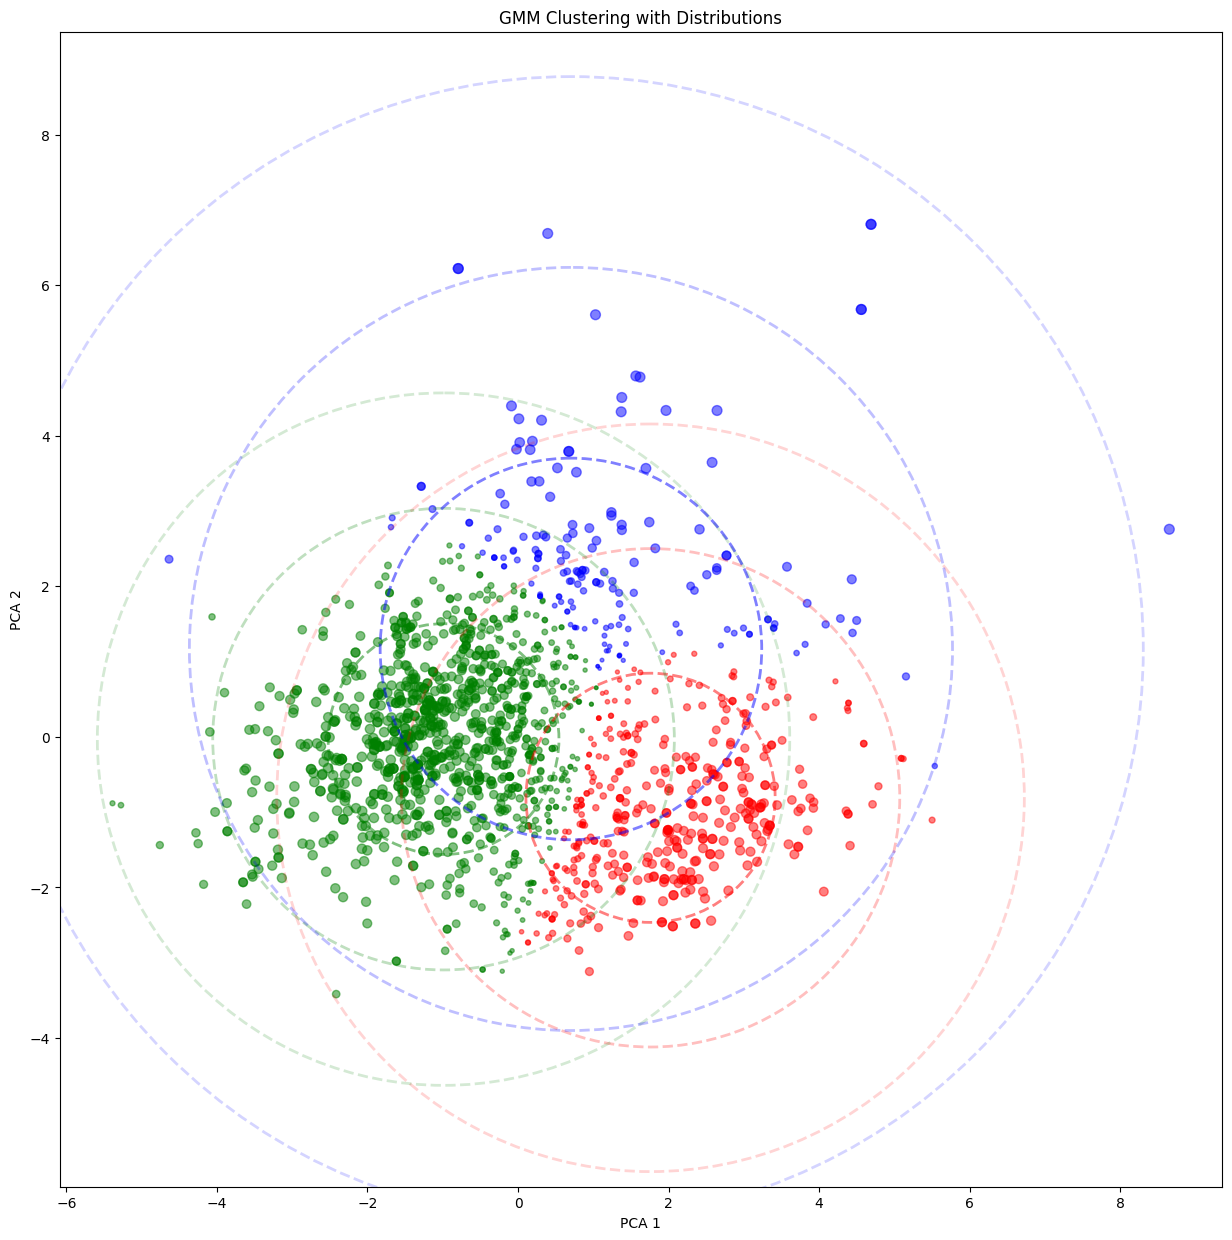

In [97]:
gmm = GMM(n_components=3, covariance_type='spherical', random_state=42)
plot_gmm(gmm, reduced_2, "PCA")

In [98]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(reduced_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[  8  51   4]
 [286 871 162]
 [106 104   7]]


In [34]:
tsne_2_comp = TSNE(n_components=2, perplexity=50)
tsne_2 = tsne_2_comp.fit_transform(scaled_features)

In [35]:
tsne_2d = pd.DataFrame(data=tsne_2, columns=['t-SNE1', 't-SNE2'])
tsne_2d['quality'] = wine['quality']

In [36]:
tsne_2_train = tsne_2d.drop('quality', axis=1)

In [37]:
gmm = GMM(n_components=3, covariance_type='full', random_state=42)

gmm.fit(tsne_2_train)

labels = gmm.predict(tsne_2_train)

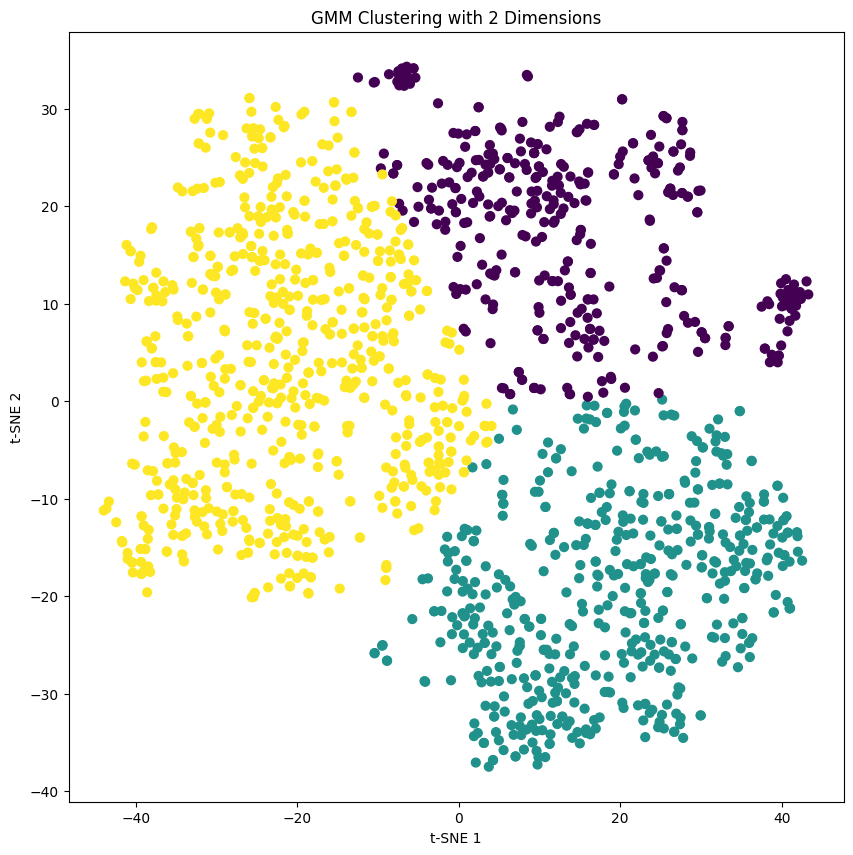

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_2d['t-SNE1'], tsne_2d['t-SNE2'], c=labels, s=40, cmap='viridis', zorder=2)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('GMM Clustering with 2 Dimensions')
plt.show()

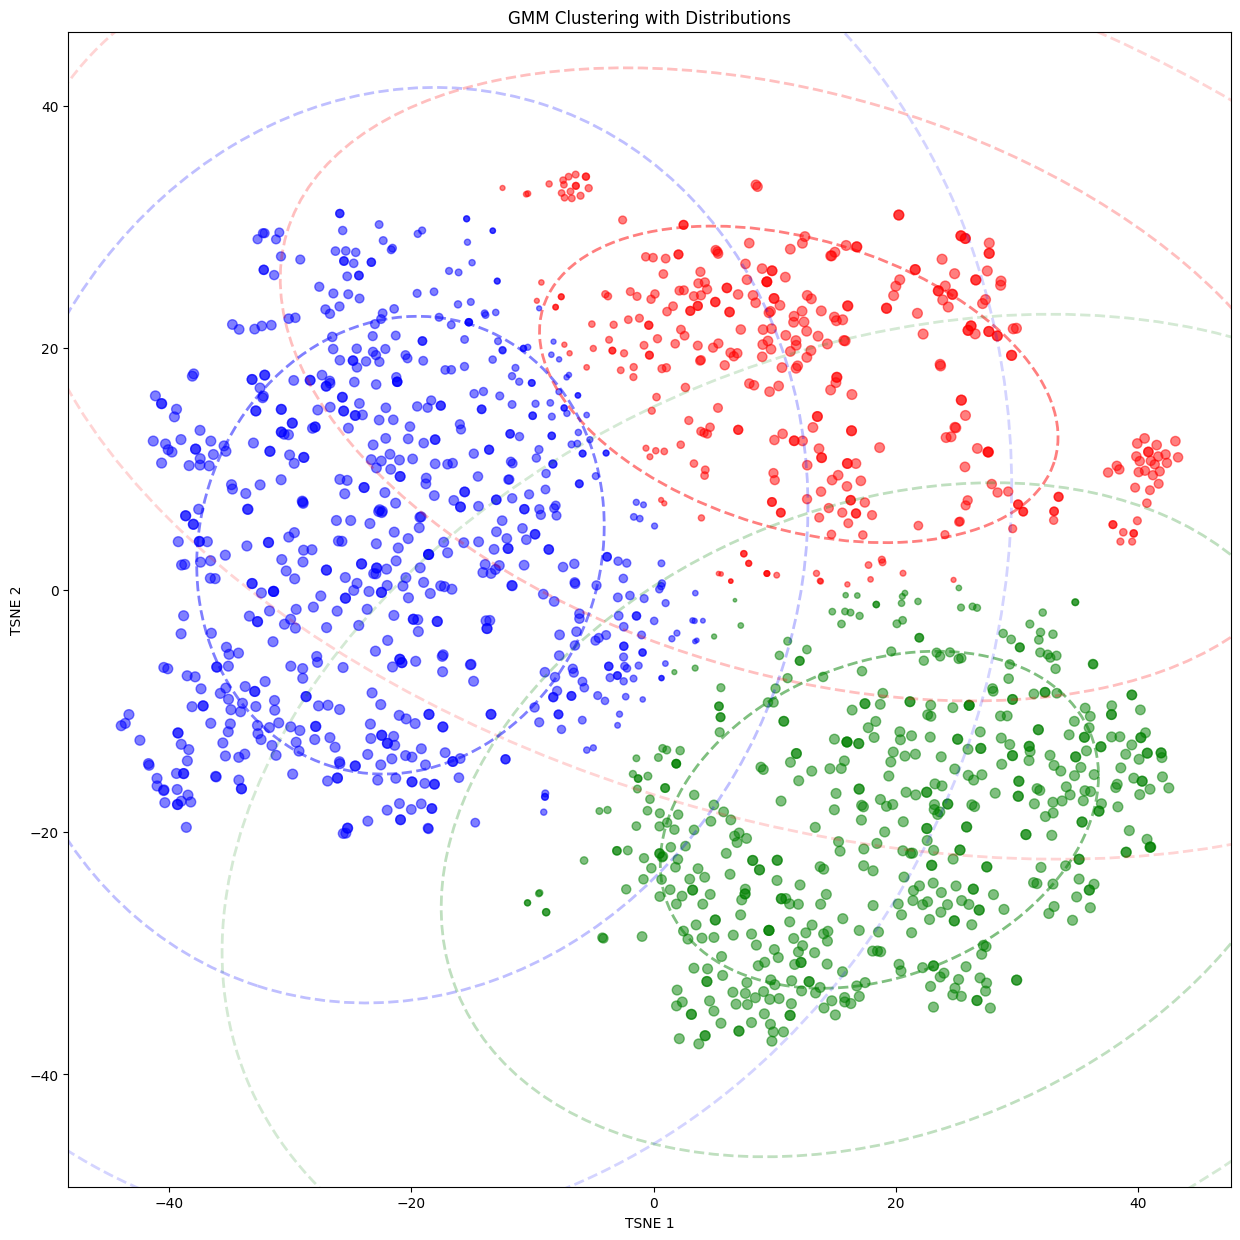

In [99]:
gmm = GMM(n_components=3, covariance_type='full', random_state=42)
plot_gmm(gmm, tsne_2, "TSNE")

In [100]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(tsne_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[   9    0   54]
 [ 125   11 1183]
 [  11    0  206]]


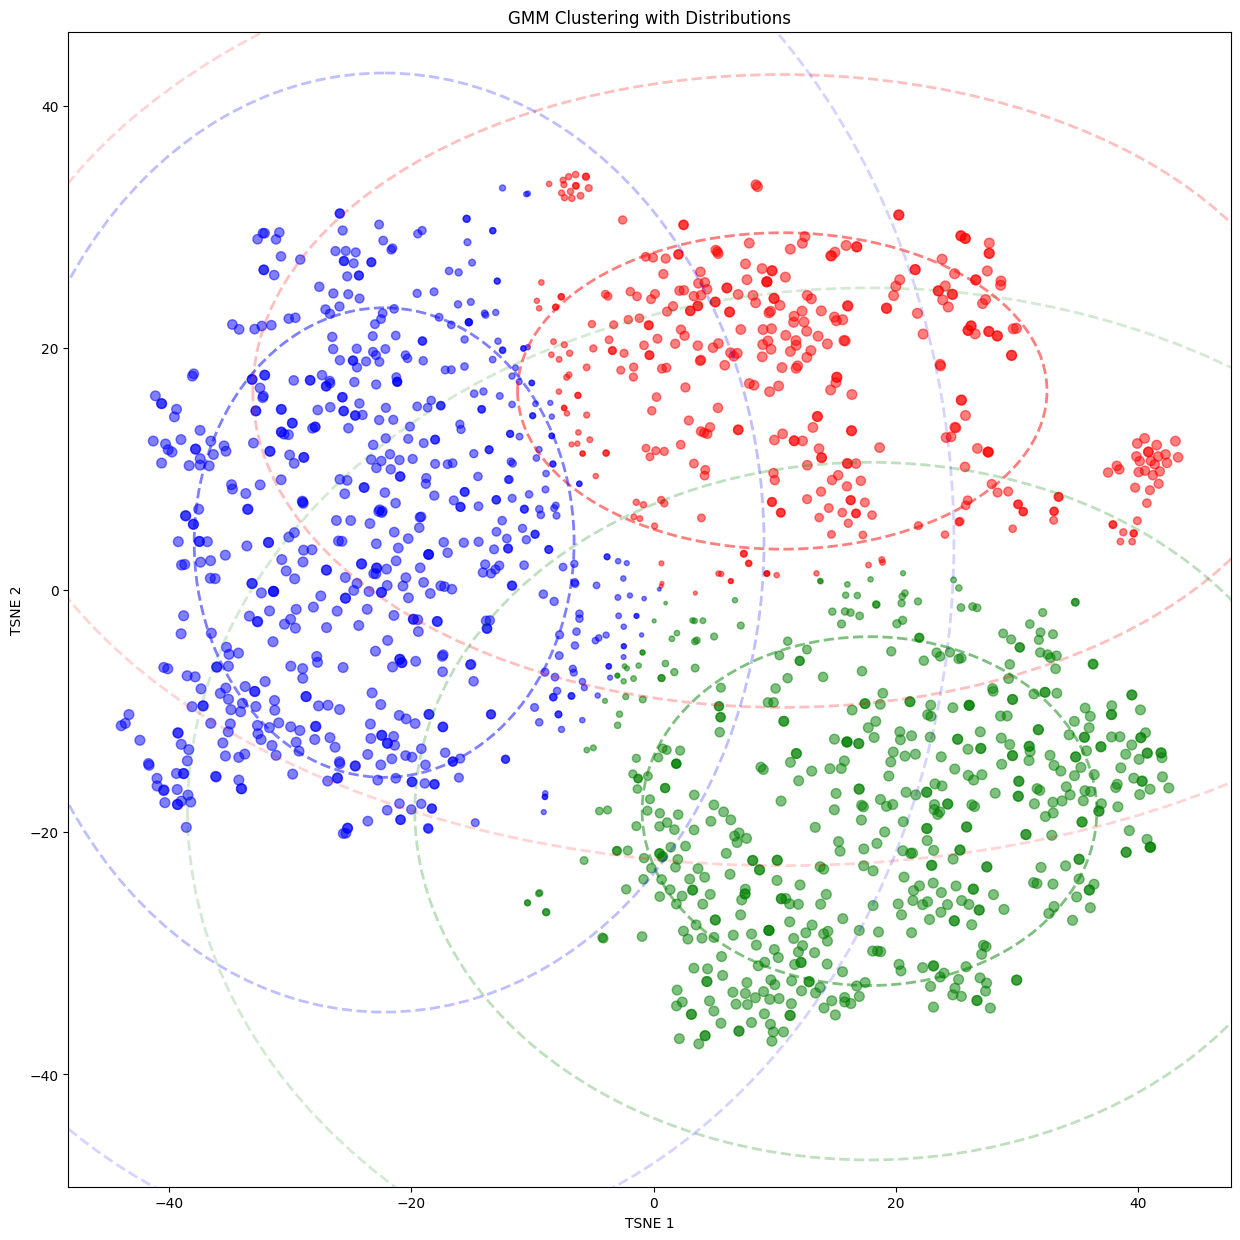

In [101]:
gmm = GMM(n_components=3, covariance_type='diag', random_state=42)
plot_gmm(gmm, tsne_2, "TSNE")

In [102]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(tsne_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[ 37   0  26]
 [515  26 778]
 [ 73   0 144]]


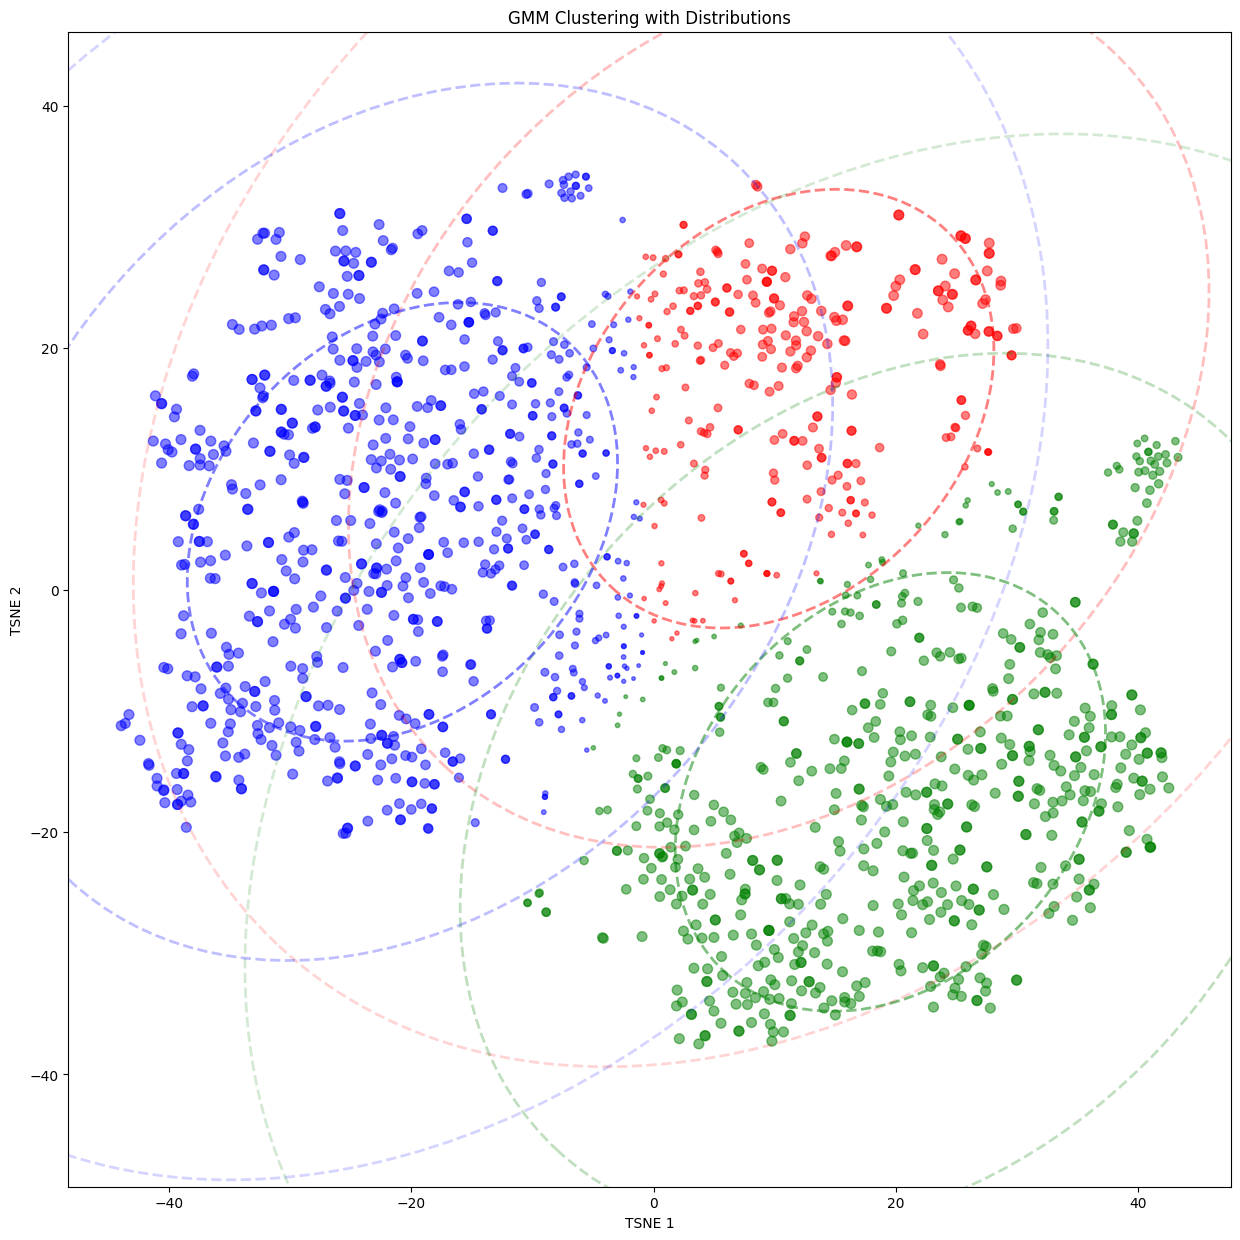

In [103]:
gmm = GMM(n_components=3, covariance_type='tied', random_state=42)
plot_gmm(gmm, tsne_2, "TSNE")

In [104]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(tsne_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[ 16   4  43]
 [506 190 623]
 [166  29  22]]


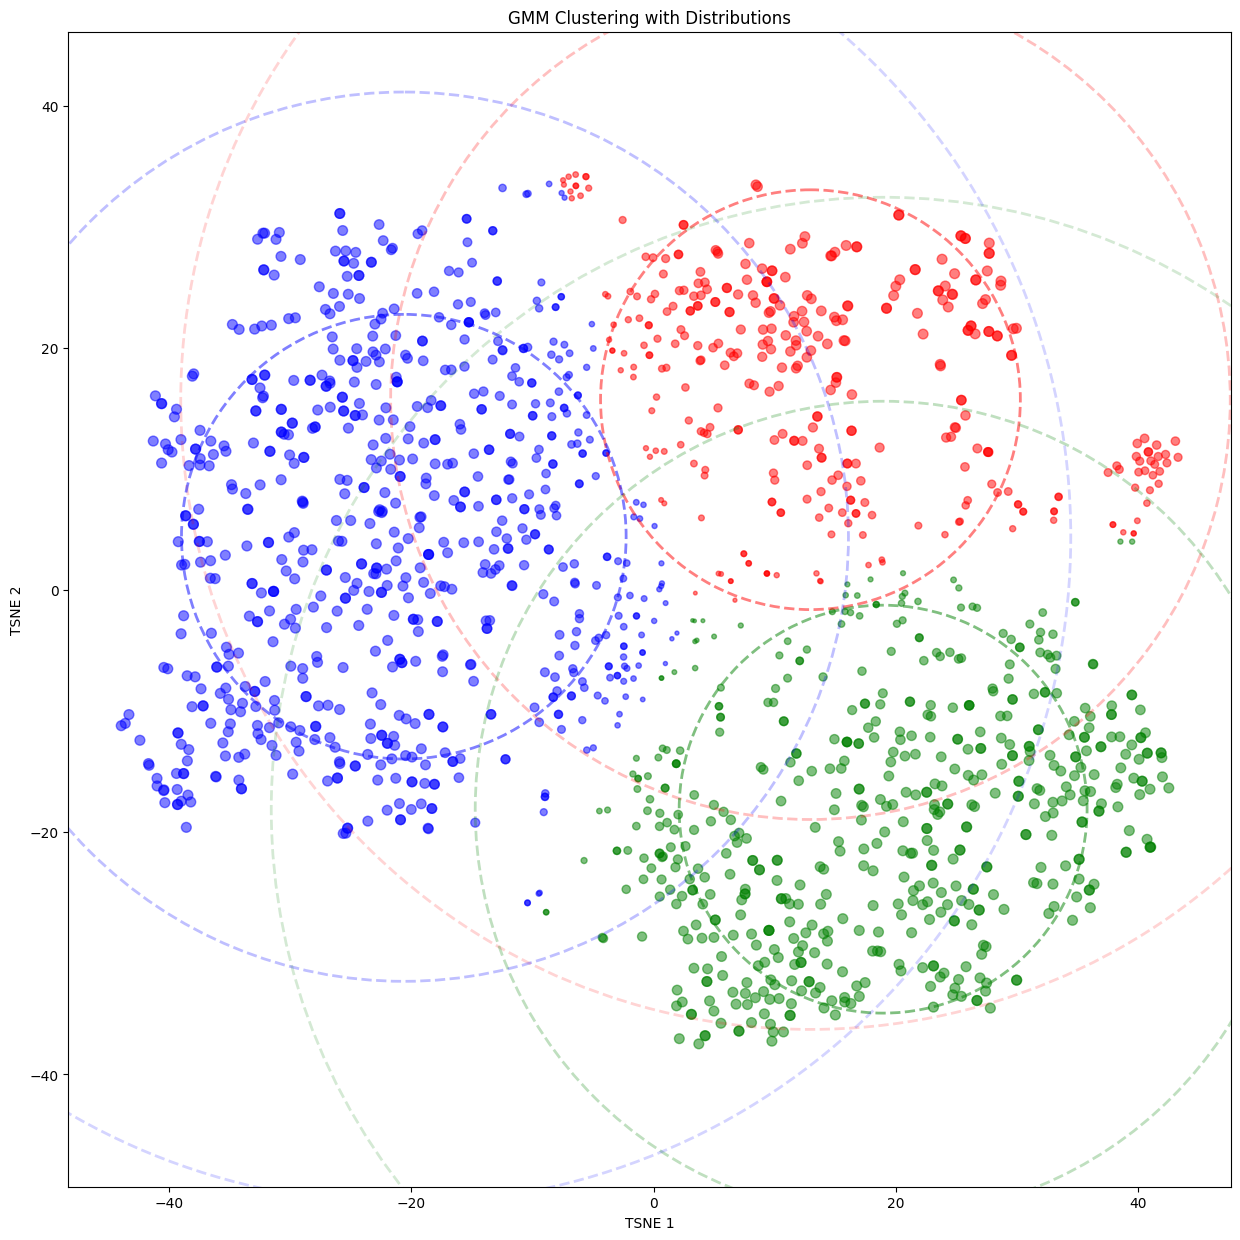

In [105]:
gmm = GMM(n_components=3, covariance_type='spherical', random_state=42)
plot_gmm(gmm, tsne_2, "TSNE")

In [106]:
gmm.fit(reduced_2)

gmm_labels = gmm.predict(tsne_2)
actual_labels = wine['quality']

actual_labels = actual_labels.apply(lambda value: 0 if value == 'low' else 1 if value == 'medium' else 2)

print(confusion_matrix(actual_labels, gmm_labels))

[[   1    0   62]
 [   9   16 1294]
 [   0    0  217]]
